In [9]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon
import numpy as np
import cv2
import torch
import supervision as sv

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("GPU is not available. Using CPU.")

GPU is available. Using GPU.


In [10]:
# Build a YOLOv9c model from pretrained weight
model = YOLO("yolov9c-seg.pt")
tracker = sv.ByteTrack()

model.to(device)


# Assuming the local image file is named 'local_image.jpg'
image_path = 'stand.jpg'

# Load the local image
image = Image.open(image_path)


image 1/1 /home/mohammaddallash/Documents/GitHub/Human-Height-Estimation/stand.jpg: 512x640 4 persons, 375.1ms
Speed: 3.1ms preprocess, 375.1ms inference, 1392.0ms postprocess per image at shape (1, 3, 512, 640)


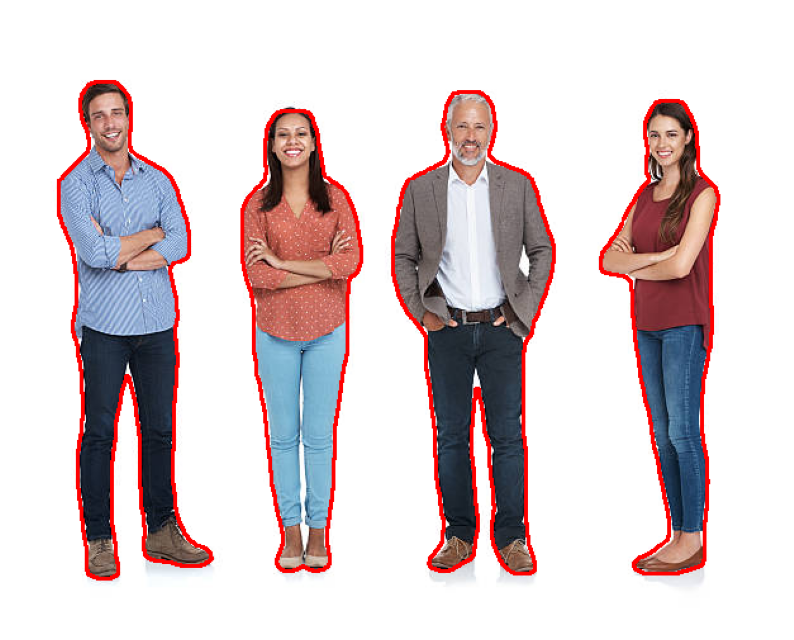

In [4]:
# Predict using the YOLO model (assuming the model and results are already obtained)
results = model(image_path, classes = [0])
masks = results[0].masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Draw polygons on the image
for mask in masks:
    poly = mask.xy
    poly = np.array(poly, dtype=np.int32)
    cv2.polylines(image, [poly], isClosed=True, color=(255, 0, 0), thickness=2)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

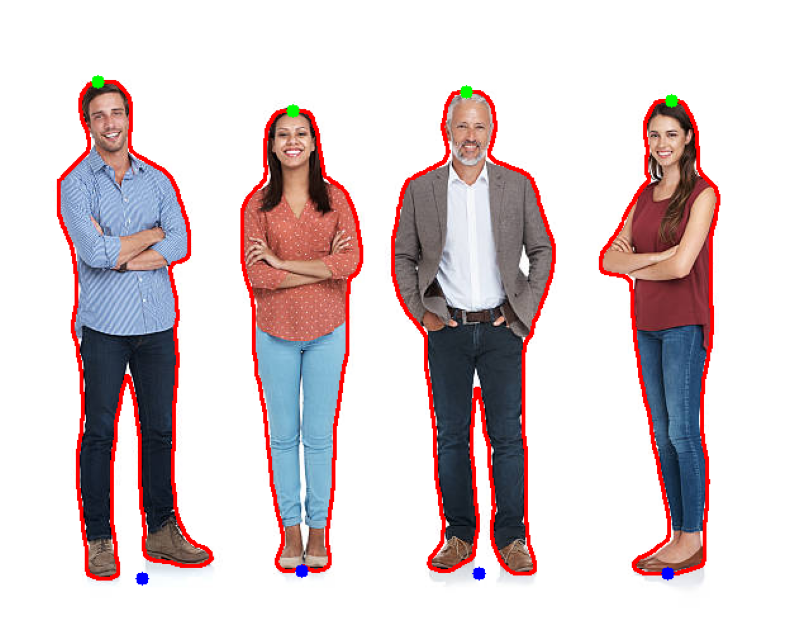

In [16]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def calculate_head_and_leg_points(polygon_points, threshold=0.12):
    """
    Calculate the average points for the head and leg based on the top and bottom threshold percentage of Y-coordinates.

    Parameters:
    polygon_points (np.array): The polygon points.
    threshold (float): The percentage to consider for the top and bottom points (default is 0.07).

    Returns:
    tuple: The average points for the head and leg.
    """
    poly = np.array(polygon_points, dtype=np.int32)

    # Extract Y-coordinates
    y_coords = poly[:, 1]

    # Calculate top and bottom threshold percentage
    top_threshold_indices = np.argsort(y_coords)[:max(int(threshold * len(y_coords)), 1)]
    bottom_threshold_indices = np.argsort(y_coords)[- max (int(threshold * len(y_coords)), 1):]

    # Get average points for head and leg
    head_points = poly[top_threshold_indices]
    leg_points = poly[bottom_threshold_indices]

    head_avg = np.mean(head_points, axis=0).astype(int)
    leg_avg = np.mean(leg_points, axis=0).astype(int)

    leg_avg[1] = np.max(y_coords)
    head_avg[1] = np.min(y_coords)


    return head_avg, leg_avg

# Assuming results are already obtained from the YOLO model
# results = model(image_path, classes=[0])
# polygon = results[0].masks[0].xy
# masks = results[0].masks

# Load the image using OpenCV
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Draw polygons on the image and mark head and leg points
for mask in masks:
    head_avg, leg_avg = calculate_head_and_leg_points(mask.xy[0])

    poly = np.array(mask.xy[0], dtype=np.int32)
    cv2.polylines(image, [poly], isClosed=True, color=(255, 0, 0), thickness=2)
    cv2.circle(image, tuple(head_avg), 5, (0, 255, 0), -1)  # Head in green
    cv2.circle(image, tuple(leg_avg), 5, (0, 0, 255), -1)   # Leg in red

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [132]:
def process_detection_results(model, frame):
    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Perform inference using the model
    results = model(frame_rgb, classes=[0], conf=0.45)[0]
    masks = results.masks
    boxes = results.boxes

    # Dictionary to store head and leg positions
    legs_and_heads = {}

    # List to store bounding boxes
    boxes_list = []

    # Iterate over each detected box and mask
    for idx, box in enumerate(boxes):
        # Convert box coordinates to list
        xyxy = box.cpu().xyxy.tolist()[0]
        boxes_list.append(xyxy)

        # Calculate head and leg positions for the current mask
        head_pos, leg_pos = calculate_head_and_leg_points(masks[idx].xy[0])
        legs_and_heads[idx] = (head_pos, leg_pos)

    return results, legs_and_heads, boxes_list

In [133]:
def get_IOU( bbox1, bbox2):
      """
      Calculate the Intersection over Union (IoU) between two bounding boxes.

      Args:
      - bbox1: Coordinates of the first bounding box in the format [x1, y1, x2, y2].
      - bbox2: Coordinates of the second bounding box in the format [x1, y1, x2, y2].

      Returns:
      - iou: Intersection over Union (IoU) score between the two bounding boxes.
      """

      x1, y1, x2, y2 = bbox1
      X1, Y1, X2, Y2 = bbox2

      # Calculate intersection area
      interArea = max(0, min(x2, X2) - max(x1, X1)) * max(0, min(y2, Y2) - max(y1, Y1))

      # Calculate areas of bounding boxes
      bbox1_area = (x2 - x1) * (y2 - y1)
      bbox2_area = (X2 - X1) * (Y2 - Y1)

      # Calculate IoU
      iou = interArea / (bbox1_area + bbox2_area - interArea)

      return iou

In [138]:
def match(xyxy, boxes):
    best_idx = 0
    best_iou = 0.0

    for idx, box in enumerate(boxes):
        iou = get_IOU(box, xyxy)

        if iou>best_iou:
            best_iou = iou
            best_idx = idx

    return best_idx


In [139]:
import cv2
import numpy as np

def detect_head_and_leg(video_path, output_video_path, model):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Couldn't open video.")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Change codec as per your need (e.g., 'MJPG')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break


        results, legs_and_heads, boxes = process_detection_results(model, frame)


        detections = sv.Detections.from_ultralytics(results)
        detections = tracker.update_with_detections(detections)


        for detection_idx, _ in enumerate(detections):
            xyxy = detections[detection_idx].xyxy.tolist()[0]
            obj_id = detections[detection_idx].tracker_id

            best_idx = match(xyxy, boxes)


            head_pos, leg_pos = legs_and_heads[best_idx]

            # Draw circles or markers for head and leg positions
            cv2.circle(frame, head_pos, 5, (0, 255, 0), -1)  # Green circle for head
            cv2.circle(frame, leg_pos, 5, (0, 0, 255), -1)   # Red circle for leg
            cv2.line(frame, head_pos, leg_pos, (255, 0, 0), 2) 
            ### draw the id in the cnter point of the head and the leg
            midpoint = ((head_pos[0] + leg_pos[0]) // 2, (head_pos[1] + leg_pos[1]) // 2)

            # Display object ID near the midpoint
            cv2.putText(frame, str(obj_id), midpoint, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)


     
        # Write the frame into the output video file
        out.write(frame)

        frame_count += 1
        print(f"Processed frame {frame_count}/{total_frames}")

    # Release everything when finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Example usage:
video_path = 'walking.mp4'
output_video_path = 'output_video.mp4'

# You need to define your YOLO model or human detection model here
# Replace with actual model usage
# model = YourModelHere()

detect_head_and_leg(video_path, output_video_path, model)



0: 384x640 3 persons, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 1/356

0: 384x640 2 persons, 33.9ms
Speed: 2.8ms preprocess, 33.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 2/356

0: 384x640 2 persons, 31.5ms
Speed: 2.2ms preprocess, 31.5ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 3/356

0: 384x640 4 persons, 38.1ms
Speed: 3.2ms preprocess, 38.1ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 4/356

0: 384x640 4 persons, 26.8ms
Speed: 2.1ms preprocess, 26.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 5/356

0: 384x640 4 persons, 28.7ms
Speed: 2.2ms preprocess, 28.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Processed frame 6/356

0: 384x640 3 persons, 24.9ms
Speed: 1.5ms preprocess, 24.9ms inference, 2.5ms postprocess per image at sh